In [1]:
import sys
import pandas as pd
import numpy as np
import ipyvolume as ipv
from scipy import optimize

import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue import config

from tyssue import Monolayer, Sheet
from tyssue import MonoLayerGeometry as geom
from tyssue.dynamics import BulkModel as model
from tyssue.generation import three_faces_sheet, extrude
from tyssue.topology.bulk_topology import IH_transition, HI_transition

from datetime import datetime
from tyssue.draw import highlight_cells

from tyssue.draw import sheet_view
from tyssue.io import hdf5

In [2]:


specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 4, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('mono', datasets, specs)

geom.center(mono)
geom.update_all(mono)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.2
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

res = Solver.find_energy_min(mono, geom, model)



Reseting datasets values with new specs


In [3]:

def view3d(mono):
    ipv.clear()
    draw_spec = config.draw.sheet_spec()
    draw_spec['face']['visible'] = True 
    draw_spec['face']['color'] = mono.face_df.area
    draw_spec['face']['color_range'] = (0, 1)
    # function plotting two meshes
    fig, meshes = sheet_view(mono, mode='3D', **draw_spec)
    fig = ipv.gcf()

    #mesh = ipv.examples.klein_bottle(show=False)
    #fig.meshes = fig.meshes + [mesh, ]
    fig.anglex = 1.0
    fig.angley = 0.2
    fig.anglez = 0.1
    
    ipv.show()
    #timestamp = datetime.now().isoformat().replace(':', '').replace('.', '_')
    #ipv.savefig(f'{mono.identifier}_{timestamp}.png')


In [4]:
view3d(mono)

In [5]:
for i in range(6):
    mono.face_df.loc[4, 'contractility'] *= 2
    res = Solver.find_energy_min(mono, geom, model)

In [6]:
highlight_cells(mono, 4)
view3d(mono)

In [7]:
ab_edges_ = ((mono.upcast_srce(mono.vert_df['segment'])
             != mono.upcast_trgt(mono.vert_df['segment'])) 
            & (mono.edge_df['cell'] == 4))

ab_edges = mono.edge_df[ab_edges_].index

mono.edge_df.loc[ab_edges, 'line_tension'] = 1e-2



In [8]:
prev_nums = mono.Nv, mono.Ne, mono.Nf

In [9]:
while mono.face_df.loc[4, 'num_sides'] > 3:
    e_min = mono.edge_df[mono.edge_df['face'] == 4]['length'].idxmin()
    prev_nums = {'edge': mono.Ne,
                 'face': mono.Nf,
                 'vert': mono.Nv}
    
    mono.settings['threshold_length'] = 1e-3
    IH_transition(mono, e_min)
    mono.face_df.loc[prev_nums['face']:, 'contractility'] = 0
    
    
    geom.update_all(mono)
    res = Solver.find_energy_min(mono, geom, model)

In [10]:
highlight_cells(mono, 4, reset_visible=True)
view3d(mono)

In [11]:
mono.cell_df.loc[4, 'prefered_vol'] *= 0.4
mono.cell_df.loc[4, 'prefered_area'] *= 0.4**(2/3)

prev_nums = {'edge': mono.Ne,
             'face': mono.Nf,
             'vert': mono.Nv}
HI_transition(mono, 4)
geom.update_all(mono)
mono.face_df.loc[prev_nums['face']:, 'contractility'] = 0

res = Solver.find_energy_min(mono, geom, model)

In [12]:
highlight_cells(mono, 4, reset_visible=True)

view3d(mono)

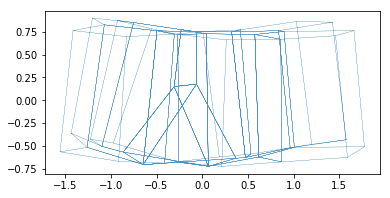

In [13]:
fig, ax = sheet_view(mono, mode='quick', coords=['x', 'z'], edge={'alpha': 0.8, 'lw': 0.2})


In [16]:
#mono.cell_df.loc[4, 'prefered_vol'] *= 0.4
mono.cell_df.loc[4, 'prefered_area'] *= 2


res = Solver.find_energy_min(mono, geom, model)
highlight_cells(mono, 4, reset_visible=True)

view3d(mono)